<a href="https://colab.research.google.com/github/khodid/2020Evening/blob/master/proj4_VAE_scenery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 처음에 시도했던 배경사진 VAE 재도전

그냥 [proj3](https://github.com/khodid/2020Evening/blob/master/proj3_MNIST_VAE.ipynb)에서 성공시킨 모델 그대로 사용할 거임

## 이미지 Import
1. Colab과 Google Drive 연결
2. dataloader 설정
3. 컴퓨팅 디바이스 설정

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


(-0.5, 47.5, 47.5, -0.5)

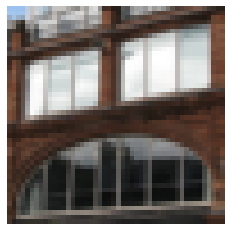

In [ ]:
import torchvision
from torchvision import transforms

root = '/content/gdrive/My Drive/Kaggle/scene-classification/train-scene classification/train'

trans= transforms.Compose([
                              transforms.Resize([48, 48]),
                              transforms.ToTensor()
])

train_data = torchvision.datasets.ImageFolder(root = root, transform= trans)

import matplotlib.pyplot as plt
showimg = train_data[10][0].numpy().transpose(1,2,0)

plt.imshow(showimg) # train_data[순서][0: 이미지 / 1: 라벨]
plt.axis('off')

In [ ]:
import torch.utils

# dataloader 설정
batch_size = 10
train_set = torch.utils.data.DataLoader(train_data, batch_size= batch_size, shuffle = True, drop_last = True)

In [ ]:
# 디바이스 설정
import torch.cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda' : torch.cuda.manual_seed_all(777)

In [ ]:
# Checking training data shape
print(type(train_set))
for img, label in train_set:
  break
print(img.shape)

<class 'torch.utils.data.dataloader.DataLoader'>
torch.Size([10, 3, 48, 48])


## 모델 설정
1. 모델 정의(기존 proj3에서 그대로 따옴)
2. 모델 테스트
3. 모델 선언

In [ ]:
import torch.nn as nn

class VAE(nn.Module):
  def __init__(self, latent_size):
    super(VAE, self).__init__()
    self.latent_size = latent_size
    self.encoder = nn.Sequential(
                                  # layer 1
                                  nn.Conv2d(3, 16, kernel_size = 5, stride = 1, padding = 2), # 3(48, 48) -> 16(48, 48)
                                  nn.BatchNorm2d(16),
                                  nn.ReLU(),
                                  
                                  #layer 2
                                  nn.Conv2d(16, 32, kernel_size = 5, stride = 2, padding=2), # 16(48, 48) -> 32(24, 24)
                                  nn.BatchNorm2d(32),
                                  nn.ReLU(),

                                  # layer 3
                                  nn. Conv2d(32, 32, kernel_size= 3, stride = 2, padding = 1), # 32(24, 24) -> 32(12, 12)
                                  nn.BatchNorm2d(32),
                                  nn.ReLU(),

                                  # output layer
                                  nn.Flatten()  # 32*12*12 = 4608
    )
    self.fc_mu = nn.Linear(4608, self.latent_size)
    self.fc_logvar = nn.Linear(4608, self.latent_size)
    self.fc_decode = nn.Linear(self.latent_size, 4608)
    self.decoder = nn.Sequential(
                                  # 
                                  # 3-T
                                  nn.ConvTranspose2d(32, 32, kernel_size = 3, stride = 2, padding=1, output_padding=1),
                                  nn.BatchNorm2d(32),
                                  nn.LeakyReLU(),

                                  # 2-T
                                  nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2, padding=2, output_padding=1),
                                  nn.BatchNorm2d(16),
                                  nn.LeakyReLU(),

                                  # 1-T
                                  nn.ConvTranspose2d(16, 3, kernel_size=5, stride=1, padding=2),
                                  nn.Sigmoid()
    )
  def reparameterize(self, mu, var):
    sigma = torch.exp(0.5*var)
    epsilon = torch.randn_like(sigma)
    return mu + sigma * epsilon

  def encode(self, img):
    h = self.encoder(img)
    mu, log_var = self.fc_mu(h), self.fc_logvar(h)
    z = self.reparameterize(mu, log_var)
    return z, mu, log_var

  def decode(self, z):
    z = self.fc_decode(z)
    new_img = self.decoder(z.view(z.size(0), 32, 12, 12))
    return new_img


====== ENCODER ======
torch.Size([20, 2])
====== DECODER ======
torch.Size([20, 3, 48, 48])


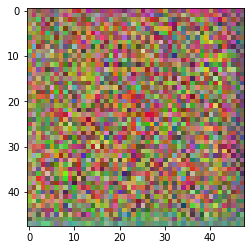

In [ ]:
# model test
with torch.no_grad():
  input = torch.randn(20, 3, 48, 48).to(device)
  model = VAE(latent_size = 2).to(device)
  test_z, _, _ = model.encode(input)
  test_out = model.decode(test_z)

  print('====== ENCODER ======')
  print(test_z.shape)
  print('====== DECODER ======')
  print(test_out.shape)

  import matplotlib.pyplot as plt
  if device == 'cuda': test_out = test_out.cpu()
  show = test_out[0].view(3, 48, 48).numpy().transpose(1,2,0)
  plt.imshow(show, cmap='gray')

In [ ]:
model = VAE(latent_size= 35).to(device)
model.train()

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Flatten()
  )
  (fc_mu): Linear(in_features=4608, out_features=35, bias=True)
  (fc_logvar): Linear(in_features=4608, out_features=35, bias=True)
  (fc_decode): Linear(in_features=35, out_features=4608, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running

## 학습
여기 역시 proj3에서 그대로 따옴

In [ ]:
def loss_function(x, target, mu, log_var):
  x, target = x.view(-1,6912), target.view(-1, 6912) # 안 넣으면 오류남
  # r_loss = torch.sqrt(torch.mean(torch.square(target - x)) + 1e-7) # p98 참고 # 0 되는 걸 방지하기 위해
  r_loss = nn.functional.binary_cross_entropy(x, target, reduction='sum')
  kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
  return r_loss, kl_div, r_loss + kl_div

In [ ]:
# 진행상황 모니터링용
tags = ['Buildings', 'Forests','Glacier', 'Mountains', 'Sea', 'Street']

def compare_img(img, new_img, label, epoch):
  with torch.no_grad():
    if device == 'cuda': img, new_img = img.cpu(), new_img.cpu()
    show_original_set = img.view(img.size(0), 3, 48, 48).numpy().transpose(0, 2,3,1)
    show_gen_set = new_img.view(new_img.size(0), 3, 48, 48).numpy().transpose(0,2,3,1)
    
    plt.figure(figsize=(15, 5))
    for i in range(8):
      show_original = show_original_set[i]
      show_gen = show_gen_set[i]

      plt.subplot(2, 8, i+1)
      plt.title('{}'.format(tags[label[i]]))
      plt.imshow(show_original, cmap='gray')
      plt.axis(False)
      plt.subplot(2, 8, i + 9)
      plt.imshow(show_gen, cmap = 'gray')
      plt.axis(False)
      
    plt.suptitle('Epoch:{}'.format(epoch+1), fontsize=16)
    plt.tight_layout()
    plt.savefig('VAE_scenery_train_{}.png'.format(epoch))
    plt.show()
    plt.clf() # 다음 그림 위해서 비워두기


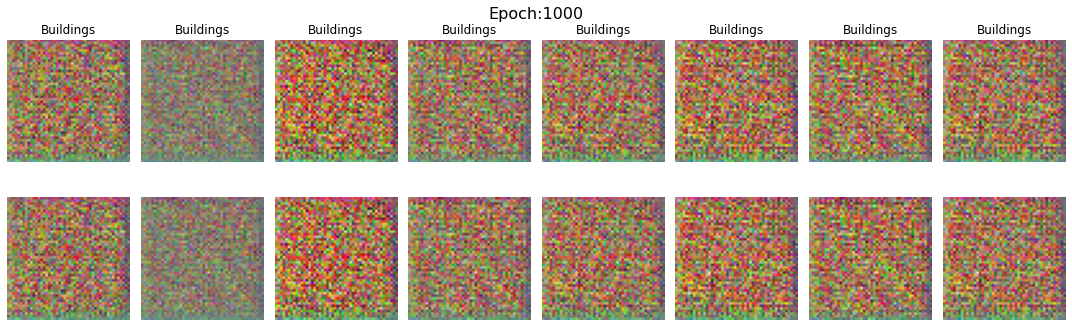

<Figure size 432x288 with 0 Axes>

In [ ]:
compare_img(test_out,test_out, [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 999)

In [ ]:
MODEL_PATH = '/content/gdrive/My Drive/Kaggle/scene-classification/vae_model.pth'

In [ ]:
def save_model(model, optimizer, epoch, loss):
  checkpoint = {'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'loss': loss}
  torch.save(checkpoint, MODEL_PATH)

In [ ]:
def load_model():
  model = VAE(latent_size= 35)
  optimizer = torch.optim.RMSprop(model.parameters(),lr = 0.001)

  checkpoint = torch.load(MODEL_PATH)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']
  return model, optimizer, epochs, loss

In [ ]:
optimizer = torch.optim.RMSprop(model.parameters(),lr = 0.001)

In [ ]:
lenth = len(train_set)
print(lenth)

1702


## Training

img = img.to(device) 부분에서 

> CUDA error: device-side assert triggered

라는 오류가 발생했는데, [https://brstar96.github.io/shoveling/device_error_summary/](https://brstar96.github.io/shoveling/device_error_summary/)를 참고 해보니 이 문제는 복합적인 원인에 의해 일어나는 듯 했다.

나는 다음과 같은 해결 방법을 시도해봤다.

1. 런타임 유형을 CPU로 변경한다.(실패)
 - GPU 프로세싱 자체에서 문제가 발생했을 수 있다고 생각하여 런타임 유형을 GPU에서 CPU로 변경해보았다. 그 결과 새로 생성한 이미지의 값이 모두 NaN으로 출력되는 현상이 발생했다. 원인을 잘 모르겠다.
2. batch size를 줄여본다. (부분 실패)
 - 기존 batch size가 20이었던 것을 10으로 줄여 본다.
 - 1에서 에러가 발생한 원인을 찾음. batch size가 10일 때도 **loss가 16자리, 18자리에 육박하는 큰 수**였고, loss를 전부 합하는 방식을 채택했기 때문에 batch size가 20일 땐 훨씬 큰 수였기 때문에 오류가 발생했던 것 같음. batch size를 5로 축소했을 때도 같은 문제 발생. batch_size\*3\*64\*64 개의 loss의 총합을 구하는 것 자체가 너무 큰 것 같아서 이미지 사이즈 자체를 좀더 줄여보기로 함.
3. 이미지 크기를 줄여 본다.(성공)
  - 기존 3X64X64로 줄였던 것을 3X48X48로 다시 한 번 축소. 이미지의 형상을 알아보는 데엔 무리가 없음.
  - 3X64X64 =12288 --> 3X48X48=6912 로 계산해야 할 데이터량을 절반으로 줄임. loss 값도 4만 대로 연산 가능한 숫자로 확 줄어든 것을 관찰할 수 있었음.

Epoch [1/50] Step [200/1702] loss: 41685.34765625 rmse: 40962.71875, kl_div: 722.6298828125
Epoch [1/50] Step [400/1702] loss: 42739.28515625 rmse: 41905.7109375, kl_div: 833.572998046875
Epoch [1/50] Step [600/1702] loss: 38544.63671875 rmse: 37849.32421875, kl_div: 695.3128662109375
Epoch [1/50] Step [800/1702] loss: 38370.28515625 rmse: 37729.5625, kl_div: 640.7216796875
Epoch [1/50] Step [1000/1702] loss: 38605.703125 rmse: 38049.59765625, kl_div: 556.1038208007812
Epoch [1/50] Step [1200/1702] loss: 42689.1171875 rmse: 42125.1484375, kl_div: 563.9677734375
Epoch [1/50] Step [1400/1702] loss: 40814.4140625 rmse: 40321.16796875, kl_div: 493.2469482421875
Epoch [1/50] Step [1600/1702] loss: 38080.34375 rmse: 37539.609375, kl_div: 540.7359619140625


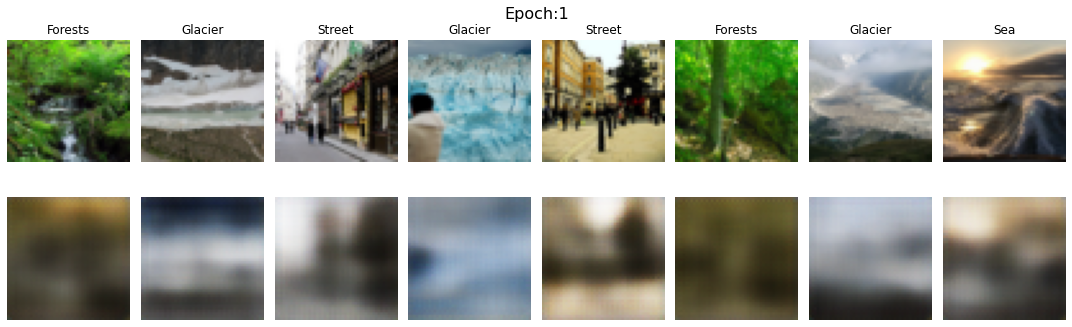

Epoch [2/50] Step [200/1702] loss: 42297.08203125 rmse: 41746.125, kl_div: 550.957275390625
Epoch [2/50] Step [400/1702] loss: 39831.21875 rmse: 39335.5703125, kl_div: 495.6475524902344
Epoch [2/50] Step [600/1702] loss: 39329.8203125 rmse: 38860.17578125, kl_div: 469.6434326171875
Epoch [2/50] Step [800/1702] loss: 41584.15625 rmse: 41108.7578125, kl_div: 475.39794921875
Epoch [2/50] Step [1000/1702] loss: 40370.76171875 rmse: 39872.6484375, kl_div: 498.11187744140625
Epoch [2/50] Step [1200/1702] loss: 39181.3359375 rmse: 38662.1015625, kl_div: 519.2332763671875
Epoch [2/50] Step [1400/1702] loss: 41427.30078125 rmse: 40885.06640625, kl_div: 542.2359008789062
Epoch [2/50] Step [1600/1702] loss: 41199.1640625 rmse: 40700.54296875, kl_div: 498.6202392578125
Epoch [3/50] Step [200/1702] loss: 41824.35546875 rmse: 41290.390625, kl_div: 533.96337890625
Epoch [3/50] Step [400/1702] loss: 39786.7890625 rmse: 39304.203125, kl_div: 482.5874328613281
Epoch [3/50] Step [600/1702] loss: 41140.06

<Figure size 432x288 with 0 Axes>

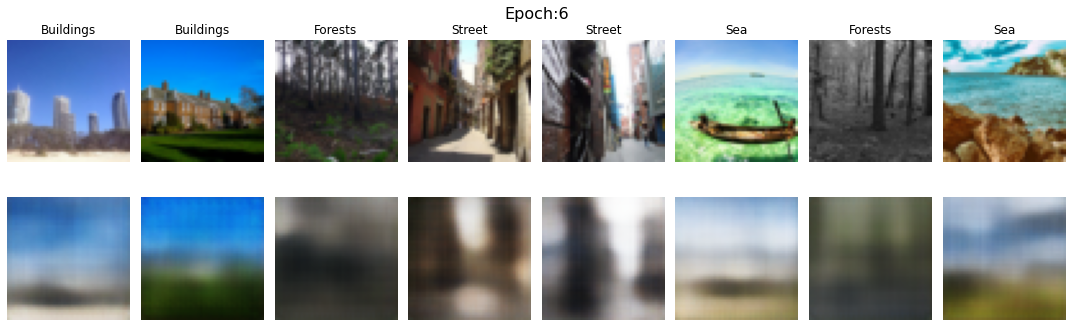

Epoch [7/50] Step [200/1702] loss: 40345.46484375 rmse: 39849.23046875, kl_div: 496.2333068847656
Epoch [7/50] Step [400/1702] loss: 40133.44140625 rmse: 39609.0859375, kl_div: 524.354736328125
Epoch [7/50] Step [600/1702] loss: 40039.34375 rmse: 39537.234375, kl_div: 502.1085205078125
Epoch [7/50] Step [800/1702] loss: 42211.46484375 rmse: 41679.0703125, kl_div: 532.3944091796875
Epoch [7/50] Step [1000/1702] loss: 40273.0546875 rmse: 39786.7109375, kl_div: 486.3447265625
Epoch [7/50] Step [1200/1702] loss: 41491.27734375 rmse: 41029.984375, kl_div: 461.29473876953125
Epoch [7/50] Step [1400/1702] loss: 40379.83203125 rmse: 39878.1796875, kl_div: 501.65234375
Epoch [7/50] Step [1600/1702] loss: 36275.93359375 rmse: 35779.265625, kl_div: 496.6683654785156
Epoch [8/50] Step [200/1702] loss: 40382.50390625 rmse: 39920.921875, kl_div: 461.5823669433594
Epoch [8/50] Step [400/1702] loss: 41474.640625 rmse: 40975.37109375, kl_div: 499.271240234375
Epoch [8/50] Step [600/1702] loss: 39271.19

<Figure size 432x288 with 0 Axes>

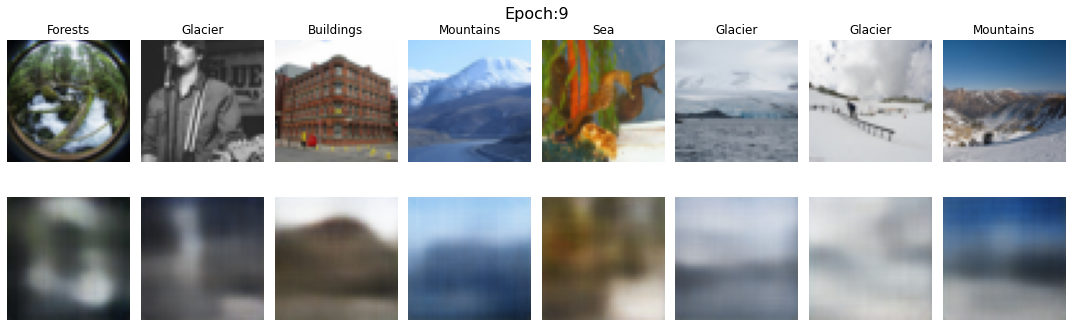

Epoch [10/50] Step [200/1702] loss: 40752.59375 rmse: 40242.68359375, kl_div: 509.9083251953125
Epoch [10/50] Step [400/1702] loss: 41441.73046875 rmse: 40904.28125, kl_div: 537.4473266601562
Epoch [10/50] Step [600/1702] loss: 40396.734375 rmse: 39912.08203125, kl_div: 484.6514892578125
Epoch [10/50] Step [800/1702] loss: 39621.0546875 rmse: 39101.5078125, kl_div: 519.5452270507812
Epoch [10/50] Step [1000/1702] loss: 40588.4609375 rmse: 40036.69140625, kl_div: 551.7698364257812
Epoch [10/50] Step [1200/1702] loss: 39927.91796875 rmse: 39469.2109375, kl_div: 458.70745849609375
Epoch [10/50] Step [1400/1702] loss: 37962.34375 rmse: 37500.5703125, kl_div: 461.7732238769531
Epoch [10/50] Step [1600/1702] loss: 37687.74609375 rmse: 37224.1328125, kl_div: 463.61444091796875
Epoch [11/50] Step [200/1702] loss: 41393.70703125 rmse: 40891.1796875, kl_div: 502.5281982421875
Epoch [11/50] Step [400/1702] loss: 38956.3984375 rmse: 38401.6328125, kl_div: 554.7654418945312
Epoch [11/50] Step [600/

<Figure size 432x288 with 0 Axes>

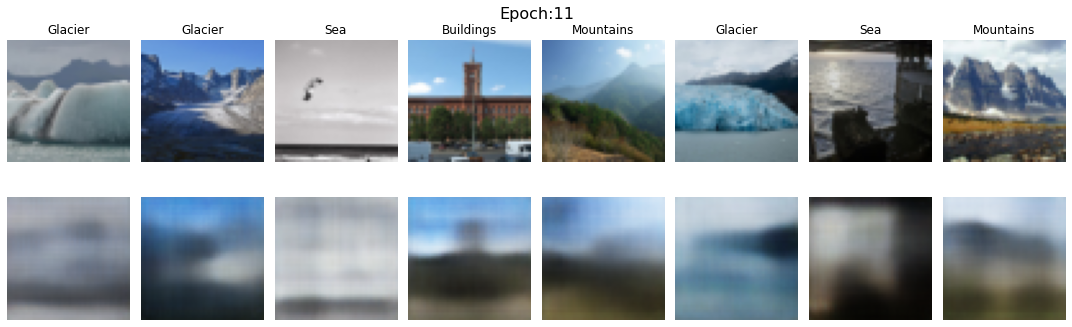

Epoch [12/50] Step [200/1702] loss: 41460.1328125 rmse: 40912.40625, kl_div: 547.724853515625
Epoch [12/50] Step [400/1702] loss: 40445.390625 rmse: 39948.15234375, kl_div: 497.2380676269531
Epoch [12/50] Step [600/1702] loss: 39324.8125 rmse: 38802.99609375, kl_div: 521.8153076171875
Epoch [12/50] Step [800/1702] loss: 37174.70703125 rmse: 36702.68359375, kl_div: 472.02362060546875
Epoch [12/50] Step [1000/1702] loss: 39559.6328125 rmse: 39063.10546875, kl_div: 496.5270080566406
Epoch [12/50] Step [1200/1702] loss: 40241.96875 rmse: 39749.20703125, kl_div: 492.7635498046875
Epoch [12/50] Step [1400/1702] loss: 39720.8046875 rmse: 39261.30859375, kl_div: 459.4972229003906
Epoch [12/50] Step [1600/1702] loss: 42444.95703125 rmse: 41907.109375, kl_div: 537.8458251953125
Epoch [13/50] Step [200/1702] loss: 42340.94140625 rmse: 41878.390625, kl_div: 462.5516357421875
Epoch [13/50] Step [400/1702] loss: 41810.765625 rmse: 41316.2109375, kl_div: 494.5549011230469
Epoch [13/50] Step [600/1702

<Figure size 432x288 with 0 Axes>

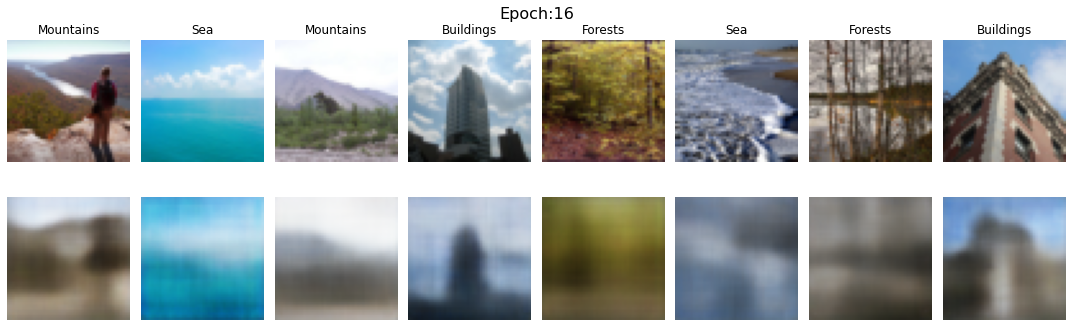

Epoch [17/50] Step [200/1702] loss: 40828.24609375 rmse: 40339.09375, kl_div: 489.15228271484375
Epoch [17/50] Step [400/1702] loss: 40973.38671875 rmse: 40479.3046875, kl_div: 494.0831298828125
Epoch [17/50] Step [600/1702] loss: 41533.23046875 rmse: 41026.796875, kl_div: 506.4321594238281
Epoch [17/50] Step [800/1702] loss: 40533.55859375 rmse: 40006.0703125, kl_div: 527.4884033203125
Epoch [17/50] Step [1000/1702] loss: 40883.9609375 rmse: 40380.4765625, kl_div: 503.4840087890625
Epoch [17/50] Step [1200/1702] loss: 40419.42578125 rmse: 39938.52734375, kl_div: 480.89666748046875
Epoch [17/50] Step [1400/1702] loss: 40402.23046875 rmse: 39919.2734375, kl_div: 482.9564208984375
Epoch [17/50] Step [1600/1702] loss: 43381.94921875 rmse: 42891.80859375, kl_div: 490.141357421875
Epoch [18/50] Step [200/1702] loss: 38969.53125 rmse: 38492.33203125, kl_div: 477.2010498046875
Epoch [18/50] Step [400/1702] loss: 40836.453125 rmse: 40373.25, kl_div: 463.2012939453125
Epoch [18/50] Step [600/17

<Figure size 432x288 with 0 Axes>

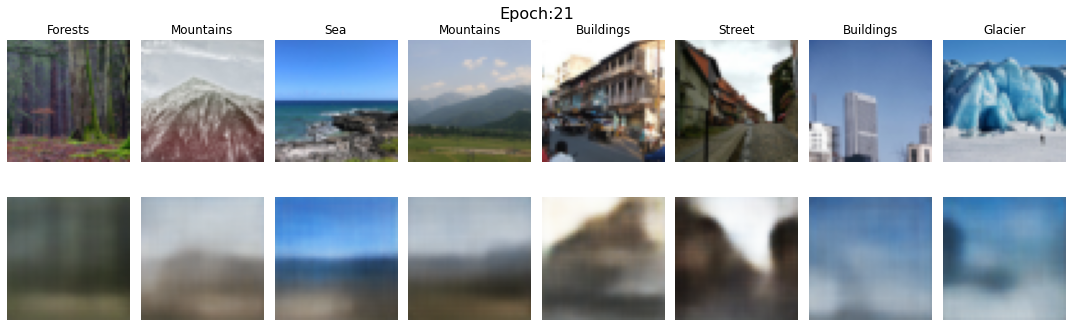

Epoch [22/50] Step [200/1702] loss: 42010.1953125 rmse: 41544.8984375, kl_div: 465.2977600097656
Epoch [22/50] Step [400/1702] loss: 39482.17578125 rmse: 38993.65625, kl_div: 488.5201721191406
Epoch [22/50] Step [600/1702] loss: 39274.15625 rmse: 38721.2578125, kl_div: 552.8967895507812
Epoch [22/50] Step [800/1702] loss: 38832.01171875 rmse: 38311.65625, kl_div: 520.355712890625
Epoch [22/50] Step [1000/1702] loss: 39145.71875 rmse: 38661.8359375, kl_div: 483.8819274902344
Epoch [22/50] Step [1200/1702] loss: 39312.48046875 rmse: 38830.68359375, kl_div: 481.7949523925781
Epoch [22/50] Step [1400/1702] loss: 40630.84765625 rmse: 40128.65625, kl_div: 502.1898498535156
Epoch [22/50] Step [1600/1702] loss: 42928.9453125 rmse: 42429.921875, kl_div: 499.0220947265625
Epoch [23/50] Step [200/1702] loss: 41051.08984375 rmse: 40563.70703125, kl_div: 487.38360595703125
Epoch [23/50] Step [400/1702] loss: 42347.49609375 rmse: 41808.921875, kl_div: 538.5738525390625
Epoch [23/50] Step [600/1702] 

<Figure size 432x288 with 0 Axes>

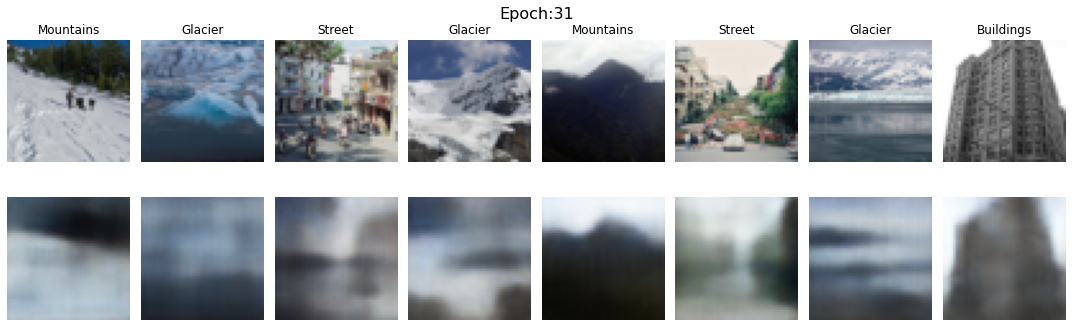

Epoch [32/50] Step [200/1702] loss: 37269.75390625 rmse: 36770.0859375, kl_div: 499.6670227050781
Epoch [32/50] Step [400/1702] loss: 39217.5 rmse: 38738.6953125, kl_div: 478.8039245605469
Epoch [32/50] Step [600/1702] loss: 39938.16015625 rmse: 39475.0390625, kl_div: 463.11993408203125
Epoch [32/50] Step [800/1702] loss: 41588.30078125 rmse: 41075.140625, kl_div: 513.1583251953125
Epoch [32/50] Step [1000/1702] loss: 39138.6484375 rmse: 38601.34765625, kl_div: 537.3017578125
Epoch [32/50] Step [1200/1702] loss: 42084.90234375 rmse: 41613.08203125, kl_div: 471.8207092285156
Epoch [32/50] Step [1400/1702] loss: 41998.109375 rmse: 41477.515625, kl_div: 520.59521484375
Epoch [32/50] Step [1600/1702] loss: 39814.62109375 rmse: 39321.0234375, kl_div: 493.5963134765625
Epoch [33/50] Step [200/1702] loss: 37263.66015625 rmse: 36768.36328125, kl_div: 495.2952880859375
Epoch [33/50] Step [400/1702] loss: 37640.97265625 rmse: 37136.27734375, kl_div: 504.6960754394531
Epoch [33/50] Step [600/1702

RuntimeError: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
epochs = 50
tick = [0, 5, 8, 10, 15, 20, 30, 50, 100, 120, 150, 180, 200] 

model.train(True)

for epoch in range(epochs):
  for idx, (img, label) in enumerate(train_set):
    img = img.to(device)
    
    z, mu, var = model.encode(img)
    new_img = model.decode(z)
    r, k, loss = loss_function(new_img, img, mu, var)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (idx+1) % 200 is 0 : print('Epoch [{}/{}] Step [{}/{}] loss: {} rmse: {}, kl_div: {}'.format(epoch+1, epochs, idx+1, lenth, loss.item(), r.item(), k.item()))

  if epoch in tick : compare_img(img, new_img, label, epoch)
  save_model(model, optimizer, epoch, loss)

compare_img(img, new_img, label, epoch+1)

In [ ]:
save_model(model, optimizer, epoch, loss)

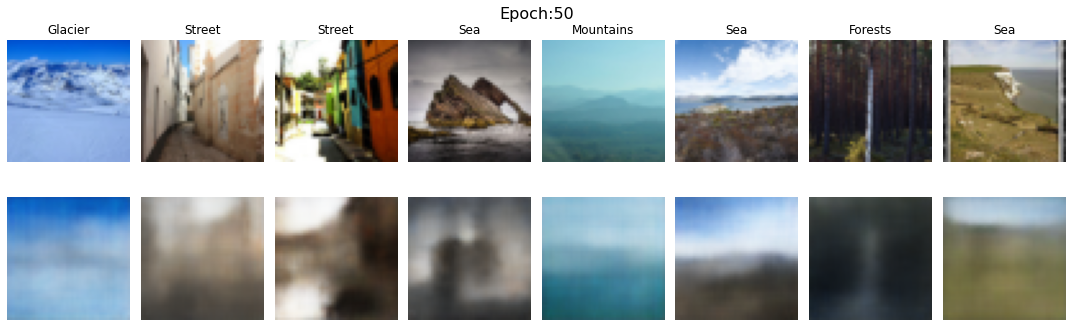

<Figure size 432x288 with 0 Axes>

In [ ]:
compare_img(img, new_img, label, epoch)

In [ ]:
print(loss)

In [ ]:
tags = ['Buildings', 'Forests', 'Mountains', 'Glacier', 'Street', 'Sea']

with torch.no_grad():
  # img[0], new_img[0], label[0]
  if device == 'cuda': img, new_img = img.cpu(), new_img.cpu()
  show_original_set = img.view(img.size(0),28, 28).numpy()
  show_gen_set = new_img.view(new_img.size(0), 28, 28).numpy()

  for i in range(8):
    show_original = show_original_set[i]
    show_gen = show_gen_set[i]

    plt.subplot(2, 8, i+1)
    plt.title('ori')
    plt.imshow(show_original, cmap='gray')
    plt.subplot(2, 8, i + 9)
    plt.title('gen')
    plt.imshow(show_gen, cmap = 'gray')
    plt.axis(False)
    
  plt.suptitle('Epoch: {}'.format(epoch+1), fontsize=16)
  plt.tight_layout()